In [2]:
import sys
import time
print(sys.executable)
from utils import *
import matplotlib.ticker as plticker
import seaborn as sns
import random
import hdbscan
time_dic = {
    2015:[(2014, 11), (2014, 12)] + ([(2015, m) for m in range(1, 11)]),
    2016:[(2015, 11), (2015, 12)] + ([(2016, m) for m in range(1, 11)]),
    2017:[(2016, 11), (2016, 12)] + ([(2017, m) for m in range(1, 11)]),
    2018:[(2017, 11), (2017, 12)] + ([(2018, m) for m in range(1, 11)]),
    2019:[(2018, 11), (2018, 12)] + ([(2019, m) for m in range(1, 11)])
}

/Users/clivian/opt/anaconda3/bin/python


<ipython-input-3-1adb5f743fcd>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)
<ipython-input-3-1adb5f743fcd>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


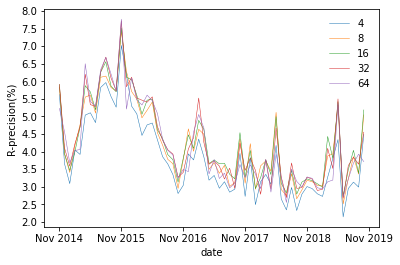

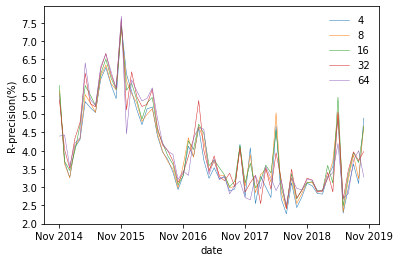

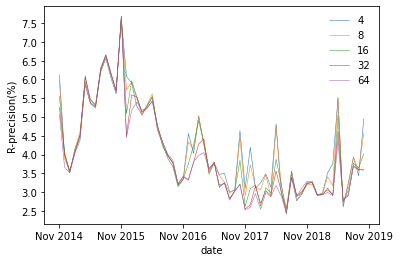

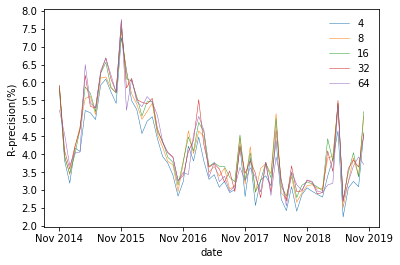

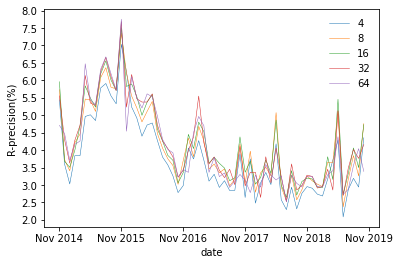

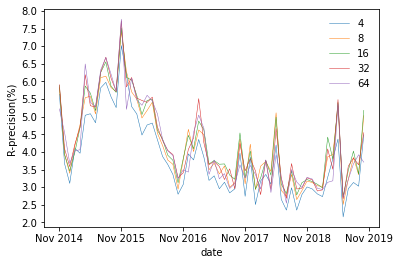

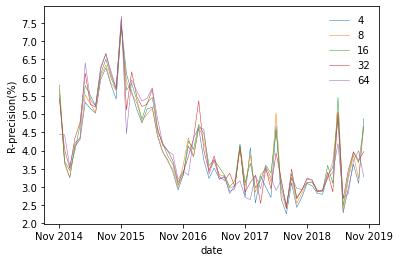

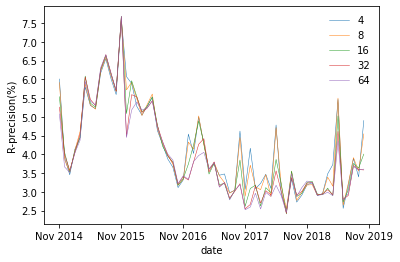

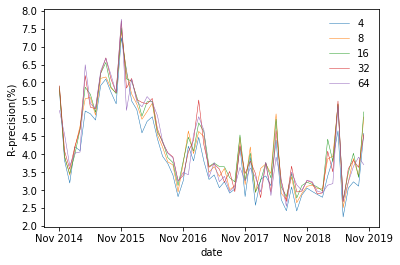

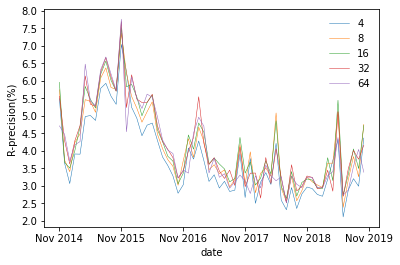

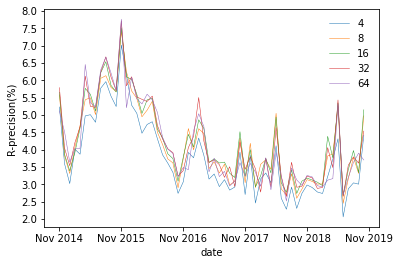

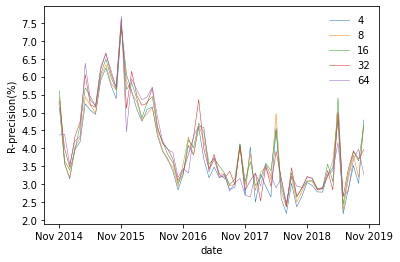

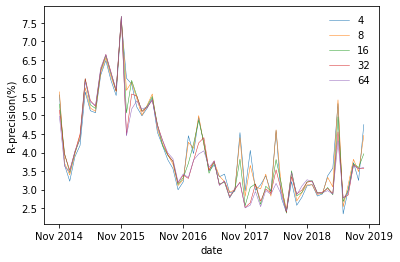

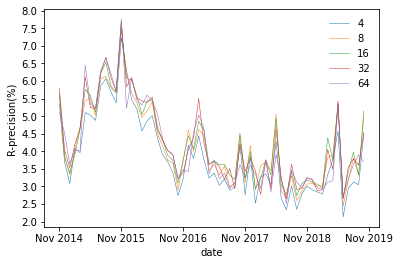

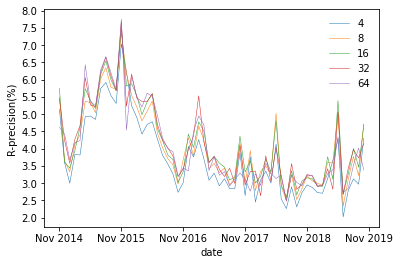

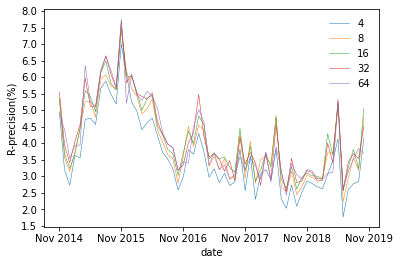

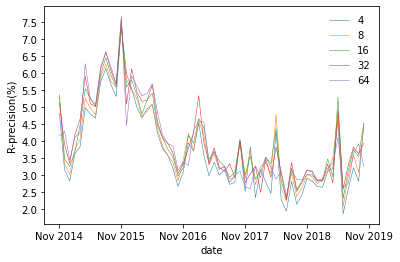

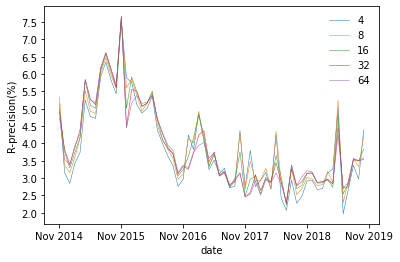

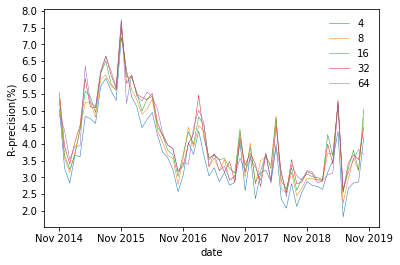

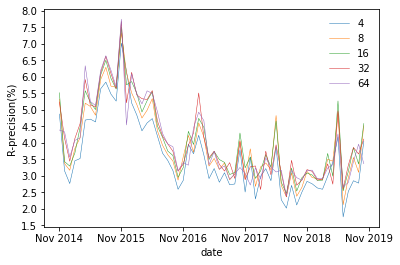

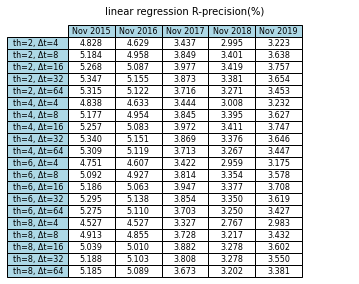

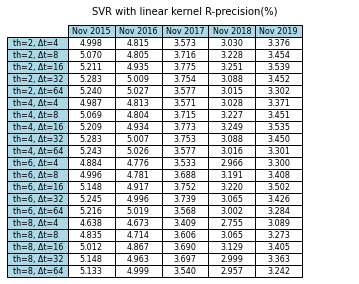

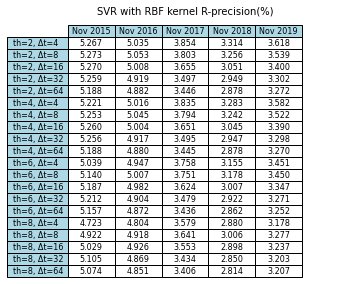

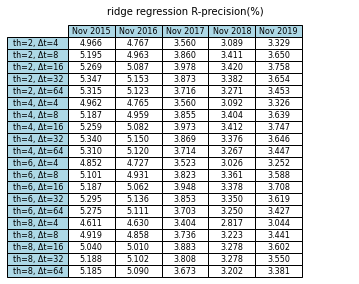

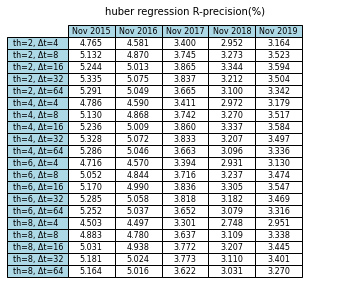

In [3]:
timeline_aves = np.load(os.path.join('data', 'day_ave_timeline_algo.npy'), allow_pickle=True).tolist()
day_aves = np.load(os.path.join('data', 'day_aves.npy'), allow_pickle=True).tolist()
threshold_list = [2, 4, 6, 8]
timeline_param_list = [4, 8, 16, 32, 64]
yearly_aves_grid = {}

for i in range(len(threshold_list)):
    timeline_year_aves = []
    timeline_month_aves = []
    timeline_methods = ['linear regression', 'SVR with linear kernel', 'SVR with RBF kernel',
                       'ridge regression', 'huber regression']
    for method in range(len(timeline_methods)):
        timeline_year_aves_per_method = []
        timeline_month_aves_per_method = []
        for j in range(len(timeline_aves[i])):
            timeline_ave = timeline_aves[i][j]
            year_ave_per_param = []
            month_ave_per_param = []
            for _year in range(2015, 2020):
                year_value = []
                for year, month in time_dic[_year]:
                    month_value = []
                    for day in range(1, 32):
                        value = timeline_ave.get((year, month, day), -1)
                        if value != -1:
                            year_value.append(value[method])
                            month_value.append(value[method])
                    month_ave_per_param.append(sum(month_value) / len(month_value) * 100)
                year_ave_per_param.append("%.3f" % (sum(year_value) / len(year_value) * 100))
            timeline_year_aves_per_method.append(year_ave_per_param)
            timeline_month_aves_per_method.append(month_ave_per_param)
            if method not in yearly_aves_grid:
                yearly_aves_grid[method] = []
            yearly_aves_grid[method].append([(threshold_list[i], timeline_param_list[j]),
                                             year_ave_per_param])
        timeline_year_aves.append(timeline_year_aves_per_method)
        timeline_month_aves.append(timeline_month_aves_per_method)
    
    # plot monthly and yearly ave
    for method in range(len(timeline_methods)):
        year_x = ['']
        temp_x = [i for i in range(0, 60)]
        for year in range(2014, 2020):
            year_x.append('Nov ' + str(year))
        fig, ax = plt.subplots()
        x_loc = plticker.MultipleLocator(base=12)
        y_loc = plticker.MultipleLocator(base=0.5)
        ax.xaxis.set_major_locator(x_loc)
        ax.yaxis.set_major_locator(y_loc)
        for j in range(0, len(timeline_param_list)):
            param = timeline_param_list[j]
            ax.plot(temp_x, timeline_month_aves[method][j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
        ax.set_xticklabels(year_x)
        ax.set_xlabel('date')
        ax.set_ylabel('R-precision(%)' )
        fig.savefig('./figures/timeline_algo_figures/monthly_average_th_2' + str(threshold_list[i])
                    + '_' + str(timeline_methods[method]), bbox_inches='tight', dpi=300)

for method in range(len(timeline_methods)):
    # prepare grid-searched yearly average
    row_headers = ['th=' + str(item[0][0]) + ', Δt=' + str(item[0][1])  
                   for item in yearly_aves_grid[method]]
    cell_text = [item[1] for item in yearly_aves_grid[method]]
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(timeline_methods[method]) + ' R-precision(%)'
        , loc='center', fontsize=10)
    table = ax.table(
        cellText = cell_text,
        rowLabels = row_headers,
        colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
        rowColours = ["lightblue"] * len(cell_text),  
        colColours = ["lightblue"] * len(cell_text[0]), 
        colWidths= [0.14] * len(cell_text[0]),
        cellLoc ='center',
        loc ='upper center',
    )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/timeline_algo_figures/yearly_average_th_2' + str(threshold_list[i])
                + '_' + str(timeline_methods[method]), bbox_inches=bbox_inches, dpi=300)

<ipython-input-4-699a40260e71>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)
<ipython-input-4-699a40260e71>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


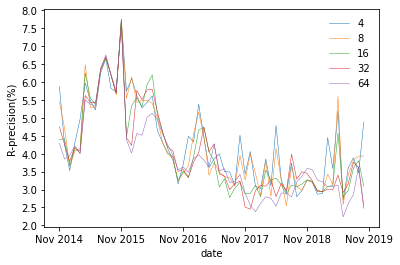

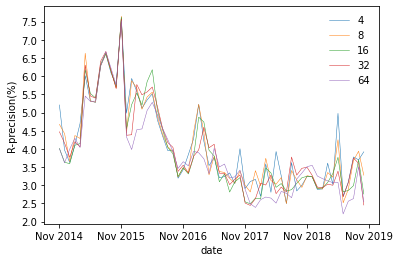

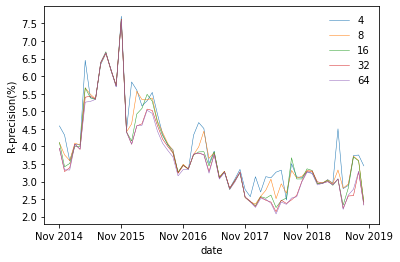

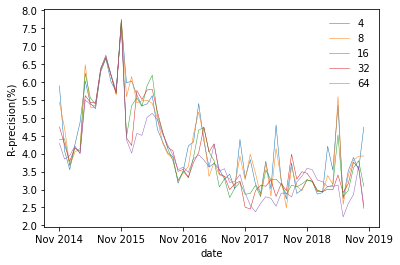

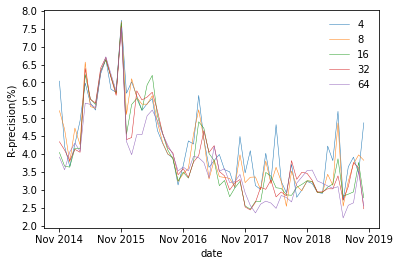

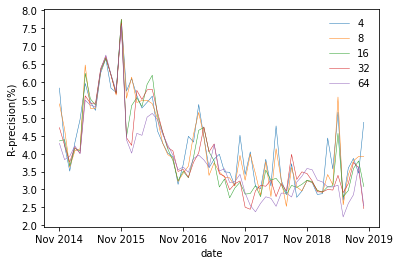

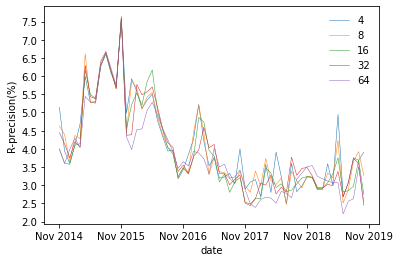

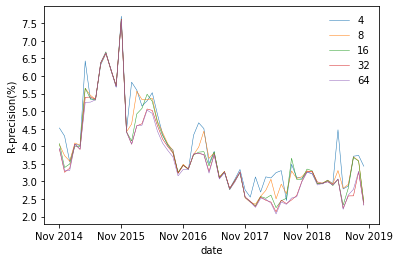

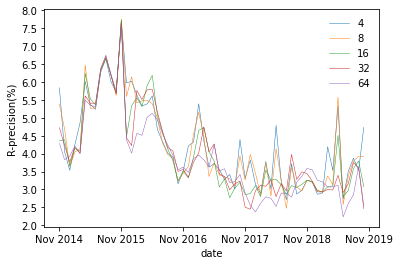

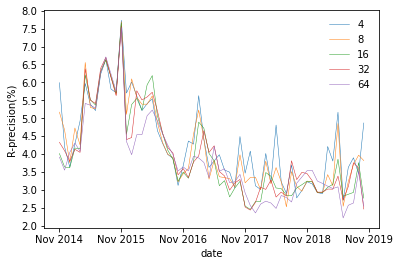

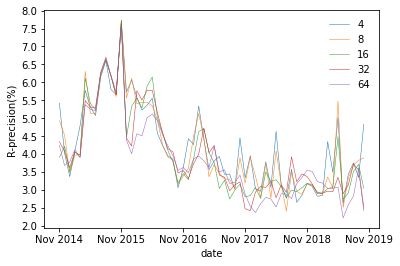

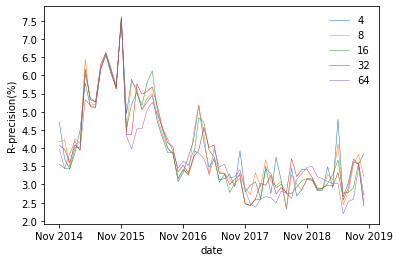

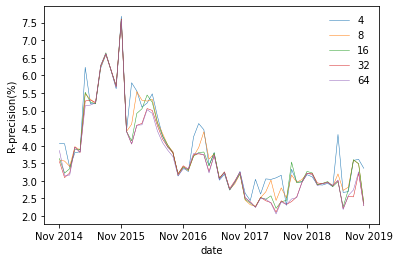

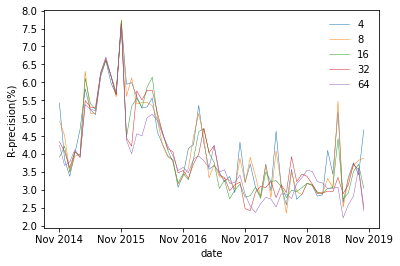

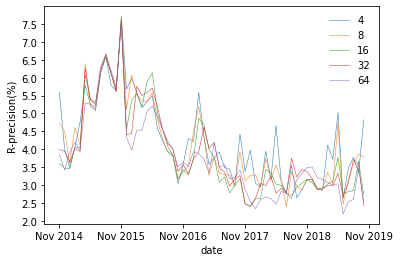

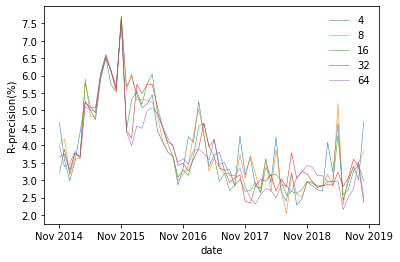

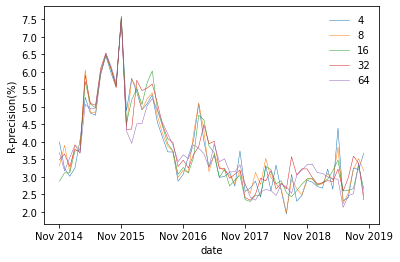

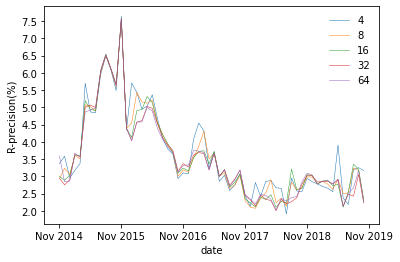

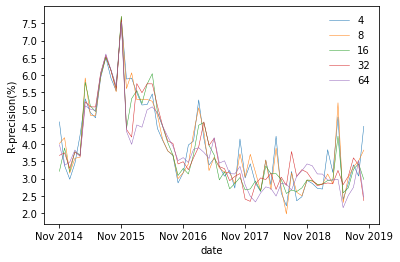

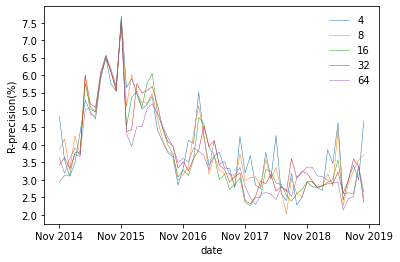

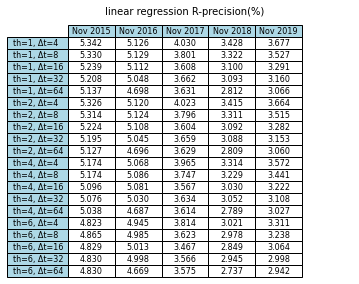

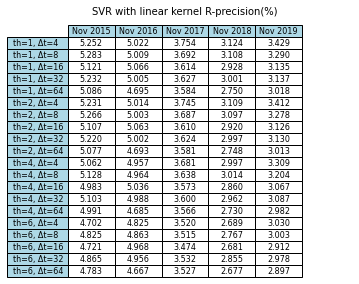

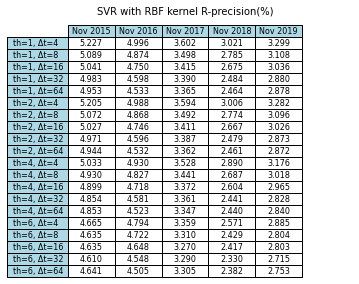

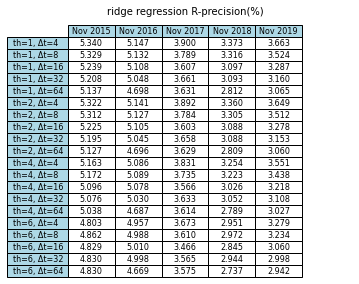

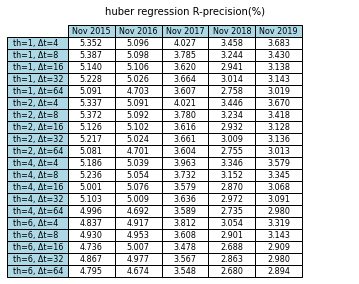

In [4]:
timeline_aves = np.load(os.path.join('data', 'day_ave_smoothed_timeline_algo.npy'), allow_pickle=True).tolist()
threshold_list = [1, 2, 4, 6]
timeline_param_list = [4, 8, 16, 32, 64]
yearly_aves_grid = {}
for i in range(len(threshold_list)):
    timeline_year_aves = []
    timeline_month_aves = []
    timeline_methods = ['linear regression', 'SVR with linear kernel', 'SVR with RBF kernel',
                       'ridge regression', 'huber regression']
    for method in range(len(timeline_methods)):
        timeline_year_aves_per_method = []
        timeline_month_aves_per_method = []
        for j in range(len(timeline_aves[i])):
            timeline_ave = timeline_aves[i][j]
            year_ave_per_param = []
            month_ave_per_param = []
            for _year in range(2015, 2020):
                year_value = []
                for year, month in time_dic[_year]:
                    month_value = []
                    for day in range(1, 32):
                        value = timeline_ave.get((year, month, day), -1)
                        if value != -1:
                            year_value.append(value[method])
                            month_value.append(value[method])
                    month_ave_per_param.append(sum(month_value) / len(month_value) * 100)
                year_ave_per_param.append("%.3f" % (sum(year_value) / len(year_value) * 100))
            timeline_year_aves_per_method.append(year_ave_per_param)
            timeline_month_aves_per_method.append(month_ave_per_param)
            if method not in yearly_aves_grid:
                yearly_aves_grid[method] = []
            yearly_aves_grid[method].append([(threshold_list[i], timeline_param_list[j]),
                                             year_ave_per_param])
        timeline_year_aves.append(timeline_year_aves_per_method)
        timeline_month_aves.append(timeline_month_aves_per_method)
    
    # plot monthly and yearly ave
    for method in range(len(timeline_methods)):
        year_x = ['']
        temp_x = [i for i in range(0, 60)]
        for year in range(2014, 2020):
            year_x.append('Nov ' + str(year))
        fig, ax = plt.subplots()
        x_loc = plticker.MultipleLocator(base=12)
        y_loc = plticker.MultipleLocator(base=0.5)
        ax.xaxis.set_major_locator(x_loc)
        ax.yaxis.set_major_locator(y_loc)
        for j in range(0, len(timeline_param_list)):
            param = timeline_param_list[j]
            ax.plot(temp_x, timeline_month_aves[method][j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
        ax.set_xticklabels(year_x)
        ax.set_xlabel('date')
        ax.set_ylabel('R-precision(%)' )
        fig.savefig('./figures/timeline_algo_figures/smoothed_monthly_average_th' + str(threshold_list[i])
                    + '_' + str(timeline_methods[method]), bbox_inches='tight', dpi=300)
for method in range(len(timeline_methods)):
    # prepare grid-searched yearly average
    row_headers = ['th=' + str(item[0][0]) + ', Δt=' + str(item[0][1])  
                   for item in yearly_aves_grid[method]]
    cell_text = [item[1] for item in yearly_aves_grid[method]]
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(timeline_methods[method]) + ' R-precision(%)'
        , loc='center', fontsize=10)
    table = ax.table(
        cellText = cell_text,
        rowLabels = row_headers,
        colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
        rowColours = ["lightblue"] * len(cell_text),  
        colColours = ["lightblue"] * len(cell_text[0]), 
        colWidths= [0.14] * len(cell_text[0]),
        cellLoc ='center',
        loc ='upper center',
    )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/timeline_algo_figures/smoothed_yearly_average_th' + str(threshold_list[i])
                + '_' + str(timeline_methods[method]), bbox_inches=bbox_inches, dpi=300)

In [13]:
day_aves = np.load(os.path.join('data', 'day_aves.npy'), allow_pickle=True).tolist()
timeline_aves = np.load(os.path.join('data', 'day_ave_timeline_algo.npy'), allow_pickle=True).tolist()
# compare all methods with optimal param  
month_aves = []
year_aves = []
yearly_pattern = []
monthly_pattern = []
weekday_pattern = []
for method in range(0, 4):
    year_ave_per_method = []
    month_ave_per_method = []
    weekday_pattern_per_method = [[] for i in range(7)]
    monthly_pattern_per_method = [[] for i in range(12)]
    yearly_pattern_per_method = [[] for i in range(5)]
    for day_ave in day_aves:
        for _year in range(2015, 2020):
            year_value = []
            for year, month in time_dic[_year]:
                month_value = []
                for day in range(1, 32):
                    value = day_ave.get((year, month, day), -1)
                    if method == 3: #timeline
                        value = timeline_aves[0][2].get((year, month, day), -1)
                    if value != -1:
                        weekday = datetime.date(year, month, day).weekday()
                        if day_ave == day_aves[2] and (method == 1 or method == 0): # deltat = 4
                            month_value.append(value[method])
                            year_value.append(value[method])
                            weekday_pattern_per_method[weekday].append(value[method])
                            monthly_pattern_per_method[month - 1].append(value[method])
                            yearly_pattern_per_method[_year - 2015].append(value[method])
                        if day_ave == day_aves[3] and method == 2: # deltat = 8
                            month_value.append(value[method])
                            year_value.append(value[method])
                            weekday_pattern_per_method[weekday].append(value[method])
                            monthly_pattern_per_method[month - 1].append(value[method])
                            yearly_pattern_per_method[_year - 2015].append(value[method])
                        if method == 3: #timeline
                            month_value.append(value[3])
                            year_value.append(value[3])
                            weekday_pattern_per_method[weekday].append(value[3])
                            monthly_pattern_per_method[month - 1].append(value[3])
                            yearly_pattern_per_method[_year - 2015].append(value[3])
                if month_value != []:
                    month_ave_per_method.append(sum(month_value) / len(month_value) * 100)
            if year_value != []:
                year_ave_per_method.append("%.3f" % (sum(year_value) / len(year_value) * 100))
        if method == 3:
            break
    year_aves.append(year_ave_per_method)
    month_aves.append(month_ave_per_method)
    weekday_pattern.append([(sum(v) / len(v) * 100) for v in weekday_pattern_per_method])
    monthly_pattern.append([(sum(v) / len(v) * 100) for v in monthly_pattern_per_method])
    yearly_pattern.append([(sum(v) / len(v) * 100) for v in yearly_pattern_per_method])

<ipython-input-14-1c6a4653de98>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)


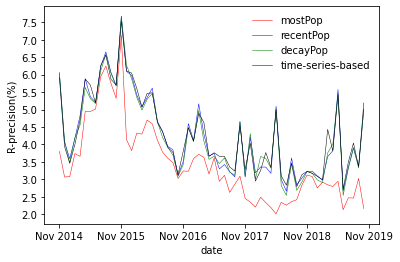

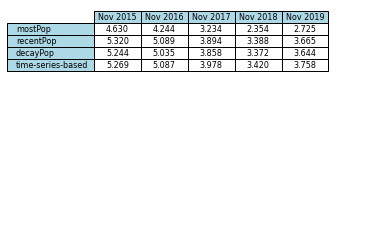

In [14]:
# plot monthly average of all methods with optimal param
colors = ['r', 'b', 'g', 'k']
methods = ['mostPop', 'recentPop', 'decayPop', 'time-series-based']
year_x = ['']
for year in range(2014, 2020):
    year_x.append('Nov ' + str(year))
year_x[0] = 'Nov 2014'
temp_x = [i for i in range(0, 60)]
fig, ax = plt.subplots()
x_loc = plticker.MultipleLocator(base=12)
y_loc = plticker.MultipleLocator(base=0.5)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
for i in range(0, len(methods)):
    ax.plot(temp_x, month_aves[i], color=colors[i], linewidth=0.5, label=str(methods[i]))
    ax.legend(loc='upper right', frameon=False)
    ax.set_xticklabels(year_x)
    ax.set_xlabel('date')
    ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/monthly_average_4_methods', bbox_inches='tight', dpi=300)

# plot yearly average
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table(
    cellText = year_aves,
    rowLabels = ['mostPop', 'recentPop', 'decayPop', 'time-series-based'],
    colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
    rowColours = ["lightblue"] * len(year_aves),  
    colColours = ["lightblue"] * len(year_aves[0]), 
    colWidths= [0.14] * len(year_aves[0]),
    cellLoc ='center',
    loc ='upper center',
)
bbox = table.get_window_extent(fig.canvas.get_renderer())
bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
fig.savefig('./figures/yearly_average_4_methods', bbox_inches=bbox_inches, dpi=300)


<ipython-input-15-7e0ec1a1a926>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
<ipython-input-15-7e0ec1a1a926>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May.', 'Jun.', 'Jul.',
<ipython-input-15-7e0ec1a1a926>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])


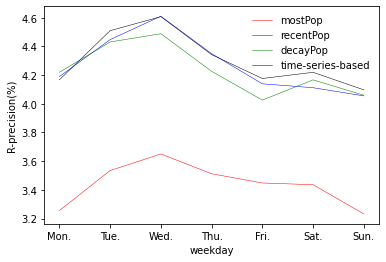

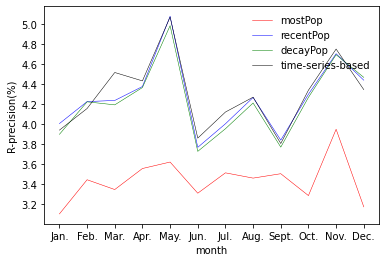

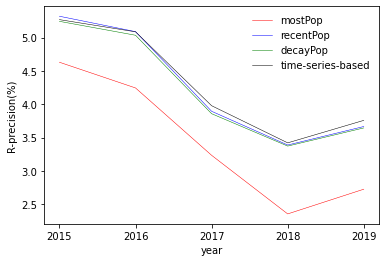

In [15]:
# weekday_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(7)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.2)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
# ax.set_title('weekday pattern', loc='center')
for i in range(4):
    ax.plot(temp_x,
            weekday_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('weekday')
ax.set_ylabel('R-precision(%)')
fig.savefig('./figures/weekday_pattern_4_methods', bbox_inches='tight', dpi=300)

# monthly_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(12)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.2)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
# ax.set_title('monthly pattern', loc='center')
for i in range(4):
    ax.plot(temp_x,
            monthly_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', 'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May.', 'Jun.', 'Jul.', 
                    'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('month')
ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/monthly_pattern_4_methods', bbox_inches='tight', dpi=300)

# yearly_pattern
fig, ax = plt.subplots()
temp_x = [i for i in range(5)]
x_loc = plticker.MultipleLocator(base=1)
y_loc = plticker.MultipleLocator(base=0.5)
ax.xaxis.set_major_locator(x_loc)
ax.yaxis.set_major_locator(y_loc)
# ax.set_title('yearly pattern', loc='center')
for i in range(4):
    ax.plot(temp_x,
            yearly_pattern[i],
            color=colors[i], linewidth=0.5, label = methods[i])
ax.set_xticklabels(['', '2015', '2016', '2017', '2018', '2019'])
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('year')
ax.set_ylabel('R-precision(%)' )
fig.savefig('./figures/yearly_pattern_4_methods', bbox_inches='tight', dpi=300)